In [ ]:
import numpy as np #used to quickly perform mathematical calculations on vectors
import pandas as pd #allows us to work with data using Pandas dataframes
import re #regular expressions -- used in this assignment to clean the text data
import sqlite3 #used to interact with the database
from collections import Counter #used to quickly count letters and words
from sklearn.feature_extraction.text import TfidfVectorizer
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#open a connection to the database
conn = sqlite3.connect('/content/gdrive/MyDrive/570/Project 01 - Database.db')

#load all documents into a Pandas dataframe named 'df', and use the 'document_id' column as the index.
#the index is used as a basis for uniquely identifying each row of data in the dataframe.
sql = 'SELECT * FROM Article'


df = pd.read_sql_query(sql, conn, index_col='id')

#close database connection
conn.close()

In [ ]:
len(df)

#Clean and prep data

In [ ]:
df = df[df['category'] != 'Unknown']

In [ ]:
def clean_text(raw_text):
  #convert the raw text to lowercase
  text = raw_text.lower()
  #remove all numbers from the text using a regular expression
  text = re.sub(r'[0-9]', ' ', text)
  #remove all underscores from the text
  text = re.sub(r'\_', ' ', text)
  #remove anything else in the text that isn't a word character (letter) or a space (e.g., punctuation, special symbols, etc.)
  text = re.sub(r'[^\w\s]', ' ', text)
  #remove any excess whitespace
  for _ in range(10): text = text.replace('  ', ' ')
  #remove any leading or trailing space characters
  text = text.strip()
  #return the clean text
  return text

In [ ]:
def clean_text2(raw_text):
  #convert the raw text to lowercase
  text = raw_text.lower()
  #remove all numbers from the text using a regular expression
  #remove all underscores from the text
  text = re.sub(r'\_', ' ', text)
  #remove anything else in the text that isn't a word character (letter) or a space (e.g., punctuation, special symbols, etc.)
  text = re.sub(r'[^\w\s]', ' ', text)
  #remove any excess whitespace
  for _ in range(10): text = text.replace('  ', ' ')
  #remove any leading or trailing space characters
  text = text.strip()
  #return the clean text
  return text

In [ ]:
df['clean_text'] = [clean_text(raw_text) for raw_text in df.raw_text]

In [ ]:
df.drop(['raw_text'], axis = 1)

,category,clean_text
id,,
6347,Politics,hiding women away in the home hidden behind ve...
13840,Sports,celtic brushed aside clyde to secure their pla...
23975,Business,british car maker aston martin has gone head t...
25850,Technology,some of the most vivid descriptions of the dev...
28514,Technology,uk mobile owners continue to break records wit...
...,...,...
9966760,Sports,wigan chairman maurice lindsay says he does no...
9967195,Technology,with home theatre systems plasma high definiti...
9981403,Technology,the us federal bureau of investigation is warn...


#Build custom vocabulary

In [ ]:
#build a vocabulary of words
all_text = ' '.join(df.clean_text) #join all of the English texts into one big string
words = all_text.split() #split the text into words
word_frequencies = Counter(words) #count all words in the text
vocabulary = list(word_frequencies.keys()) #get a list of all unique words

vocabulary.sort()
#use slicing to show the first 20 words in the vocabulary
vocabulary[:20]
#display the total number of unique words in the vocabulary

#Check this no data
len(vocabulary)
l1 = []
count = 0
for item in vocabulary:
    if item not in l1:
        count += 1
        l1.append(item)

print("No of unique items are:", count)

No of unique items are: 21860


In [ ]:
#ensure that the vocabulary is sorted
vocabulary.sort()
#define a collection (list) to hold the raw frequencies for each word in each document
document_word_frequencies = []
#define a collection (list) to hold the total number of words in each document
document_total_words = []
idfs = []
idft = []
idzz = []
#compute the word frequencies and total number of words for each document in the English-language corpus
for current_document in df.itertuples(): #for each document (row) in the English-language dataframe
  words = current_document.clean_text.split() #split the (clean) text for the current document into words
  total_words = len(words) #compute the total number of words in the document
  #identify all unique words in the document's (clean) text, and count how many times each
  #word appears in the document
  word_frequencies = Counter(words)
  #compute the document's raw word frequencies for every word in the VOCABULARY 
  if words in current_document:
    idft.append(1)
  else:
    idft.append(0)
  vocabulary_word_frequencies = []
  idfstemp = []
  #for each word in the vocabulary
  for vocabulary_word in vocabulary:
    #if this vocabulary word appears in the document
    if vocabulary_word in word_frequencies:
      #add the number of times this vocabulary word appears in the document to the collection
      vocabulary_word_frequencies.append(word_frequencies[vocabulary_word])
      idfstemp.append(1)
    else: #if this vocabulary word doesn't appear in the document
      #add a value of zero for this vocabulary word to the collection (since this
      #vocabulary word appears zero times in the current document)
      vocabulary_word_frequencies.append(0)
      idfstemp.append(0)

  #add this document's vocabulary word frequencies to the collection
  document_word_frequencies.append(vocabulary_word_frequencies)
  #add this document's total number of words to the collection
  document_total_words.append(total_words)

  idfs.append(idfstemp)
  idzz.append(idft)

#add the raw word frequencies and total word counts for each document to the
#English-language dataframe as new columns.
df['word_frequencies'] = document_word_frequencies
df['total_words'] = document_total_words
df['exists'] = idfs


#show the first few rows in the dataframe

In [ ]:

custom_vocab = vocabulary


In [ ]:
tfidf = TfidfVectorizer(vocabulary=custom_vocab)

# Fit and transform the document column using the TfidfVectorizer
tfidf_matrix = tfidf.fit_transform(df['clean_text'],)

#Multi Class Logisitic Classification Model

In [ ]:
train_data, test_data = train_test_split(df, test_size=0.2)

train_data = df

# Initialize the TfidfVectorizer with the custom vocabulary
tfidf = TfidfVectorizer(vocabulary=custom_vocab)

# Fit and transform the training data using the TfidfVectorizer
tfidf_matrix_train = tfidf.fit_transform(train_data['clean_text'])

# Train a logistic regression model on the TF-IDF matrix and the corresponding document labels
clf = LogisticRegression()
clf.fit(tfidf_matrix_train, train_data['category'])

# Transform the test data using the TfidfVectorizer
tfidf_matrix_test = tfidf.transform(test_data['clean_text'])

# Use the trained classifier model to predict the category of the test data based on their TF-IDF scores
predictions = clf.predict(tfidf_matrix_test)

# Print the predictions and the corresponding true labels
print('Predictions:', predictions)
print('True labels:', test_data['category'])

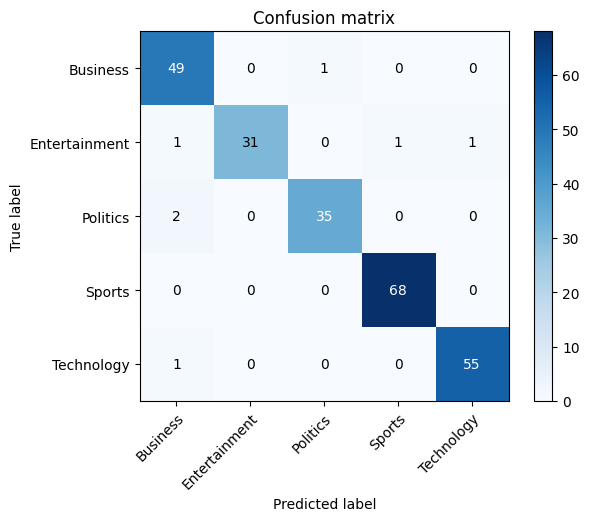

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

cm = confusion_matrix(test_data['category'], predictions)

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Add axis labels
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=clf.classes_, yticklabels=clf.classes_,
       title='Confusion matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Add annotations
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

# Rotate the x-axis labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Show the plot
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_data['category'], predictions)
print('Accuracy:', accuracy)

Accuracy: 0.9591836734693877


#Predictions

In [ ]:
conn = sqlite3.connect('/content/gdrive/MyDrive/570/Project 01 - Database.db')

#load all documents into a Pandas dataframe named 'df', and use the 'document_id' column as the index.
#the index is used as a basis for uniquely identifying each row of data in the dataframe.
sql = 'SELECT * FROM Article'
df2 = pd.read_sql_query(sql, conn, index_col='id')
dfp = df2[df2['category'] == 'Unknown']

In [ ]:
df2['category'][df2['category'] == 'Unknown']

id
14775      Unknown
16641      Unknown
17511      Unknown
19326      Unknown
19971      Unknown
            ...   
9951082    Unknown
9952845    Unknown
9954056    Unknown
9986243    Unknown
9987006    Unknown
Name: category, Length: 1000, dtype: object

In [ ]:
dfp['clean_text'] = [clean_text(raw_text) for raw_text in dfp.raw_text]

In [ ]:
tfidf_matrix2 = tfidf.transform(dfp['clean_text'])

In [ ]:
predictions = clf.predict(tfidf_matrix2)

In [ ]:
predictions_df = pd.DataFrame(predictions, columns=['predicted_category'], index=dfp.index)

# Merge the predictions DataFrame with the original test data
merged_data = pd.merge(dfp, predictions_df, left_index=True, right_index=True)

print(merged_data)

        category                                           raw_text  \
id                                                                    
14775    Unknown  If you have finished Doom 3, Half Life 2 and H...   
16641    Unknown  Controversial new UK casinos will be banned fr...   
17511    Unknown  Justine Henin-Hardenne lost to Elena Dementiev...   
19326    Unknown  The two most senior executives at US mortgage ...   
19971    Unknown  Munster's Heineken Cup quarter-final tie again...   
...          ...                                                ...   
9951082  Unknown  The Incredibles movie has beaten Shrek 2 to th...   
9952845  Unknown  The Karachi Stock Exchange (KSE) has recorded ...   
9954056  Unknown  Britain's Jason Gardener enjoyed a double 60m ...   
9986243  Unknown  The US economy has grown more than expected, e...   
9987006  Unknown  Three years after a gruelling economic crisis,...   

                                                clean_text predicted_categor

In [ ]:
#Final Model
merged_data.head(100)

In [ ]:
# Merge the prediction DataFrame with the original DataFrame based on the ID column
merged_df = dfp.merge(predictions_df, left_index=True, right_on='id')

# Print the merged DataFrame to verify the predictions have been added
merged_df.head()

# merged_df['check'] = (merged_df['predicted_category'])

# merged_df[merged_df['check'] == False].count()

,category,raw_text,clean_text,predicted_category
id,,,,
14775,Unknown,"If you have finished Doom 3, Half Life 2 and H...",if you have finished doom half life and halo d...,Technology
16641,Unknown,Controversial new UK casinos will be banned fr...,controversial new uk casinos will be banned fr...,Politics
17511,Unknown,Justine Henin-Hardenne lost to Elena Dementiev...,justine henin hardenne lost to elena dementiev...,Sports
19326,Unknown,The two most senior executives at US mortgage ...,the two most senior executives at us mortgage ...,Business
19971,Unknown,Munster's Heineken Cup quarter-final tie again...,munster s heineken cup quarter final tie again...,Sports


In [ ]:
merged_df.head(1000)

In [ ]:
dfp.head()

,category,raw_text,clean_text,predicted_category
id,,,,
14775,Unknown,"If you have finished Doom 3, Half Life 2 and H...",if you have finished doom half life and halo d...,Technology
16641,Unknown,Controversial new UK casinos will be banned fr...,controversial new uk casinos will be banned fr...,Politics
17511,Unknown,Justine Henin-Hardenne lost to Elena Dementiev...,justine henin hardenne lost to elena dementiev...,Sports
19326,Unknown,The two most senior executives at US mortgage ...,the two most senior executives at us mortgage ...,Business
19971,Unknown,Munster's Heineken Cup quarter-final tie again...,munster s heineken cup quarter final tie again...,Sports


Ecludians Distance TFIDF

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

from sklearn.feature_extraction.text import TfidfVectorizer

# create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# load training data
train_data = df
train_data = train_data.reset_index(drop=True)
# calculate TF-IDF vectors for each document
tfidf_vectors = tfidf_vectorizer.fit_transform(train_data['clean_text'])

# get category labels
categories = train_data['category'].unique()

# calculate average TF-IDF vector for each category
category_tfidf_vectors = {}
for category in categories:
    category_indices = train_data[train_data['category'] == category].index
    category_tfidf_vectors[category] = np.mean(tfidf_vectors[category_indices], axis=0)

# function to predict category of new document based on Euclidean distance
def predict_category_euclidean(doc_tfidf, category_tfidf_vectors):
    distances = []
    for category, avg_tfidf in category_tfidf_vectors.items():
        distance = np.linalg.norm(doc_tfidf - avg_tfidf)
        distances.append((category, distance))
    return min(distances, key=lambda x: x[1])[0]


In [ ]:

for idx, doc in merged_data.iterrows():
    # calculate the tfidf vector for the document
    doc_tfidf = tfidf_vectorizer.transform([doc['clean_text']])
    # predict the category using the euclidean distance method
    category = predict_category_euclidean(doc_tfidf.toarray()[0], category_tfidf_vectors)
    # store the prediction in the new column
    merged_data.at[idx, 'predicted_category_euclidean'] = category

In [ ]:
merged_data.iloc[-1]

category                                                                  Unknown
raw_text                        Three years after a gruelling economic crisis,...
clean_text                      three years after a gruelling economic crisis ...
predicted_category                                                       Business
predicted_category_euclidean                                             Business
correct_ec                                                                   True
id                                                                        9987006
Name: 9987006, dtype: object

In [ ]:
merged_data['correct_ec'] = merged_data['predicted_category_euclidean'] == merged_data['predicted_category']

merged_data[merged_data['correct_ec'] == False].count()

category                        29
raw_text                        29
clean_text                      29
predicted_category              29
predicted_category_euclidean    29
correct_ec                      29
dtype: int64

In [ ]:

merged_data[merged_data['correct_ec'] == False]

,category,raw_text,clean_text,predicted_category,predicted_category_euclidean,correct_ec,id
id,,,,,,,
16641,Unknown,Controversial new UK casinos will be banned fr...,controversial new uk casinos will be banned fr...,Politics,Technology,False,16641
470374,Unknown,MPs will be thrown out of the Commons if they ...,mps will be thrown out of the commons if they ...,Politics,Technology,False,470374
571270,Unknown,The Trades Union Congress (TUC) is calling on ...,the trades union congress tuc is calling on th...,Politics,Business,False,571270
822248,Unknown,The creator of defunct TV soap Brookside has w...,the creator of defunct tv soap brookside has w...,Politics,Entertainment,False,822248
871291,Unknown,"A US airline attendant suspended over ""inappro...",a us airline attendant suspended over inapprop...,Technology,Business,False,871291
1350881,Unknown,"A US woman is suing Hewlett Packard (HP), sayi...",a us woman is suing hewlett packard hp saying ...,Technology,Business,False,1350881
1405917,Unknown,Rock star Ozzy Osbourne has been praised by po...,rock star ozzy osbourne has been praised by po...,Entertainment,Sports,False,1405917
1568110,Unknown,Hospital waiting times for patients in Wales a...,hospital waiting times for patients in wales a...,Politics,Business,False,1568110
1766390,Unknown,Support for a ban on hunting has fallen in the...,support for a ban on hunting has fallen in the...,Politics,Business,False,1766390


In [ ]:
merged_data.to_csv('Cameron, Safai.csv', columns=['predicted_category'],index=True, header=False)

In [ ]:
merged_data['id'] = merged_data.index

In [ ]:
df_predict = pd.DataFrame([merged_data['predicted_category'],merged_data['raw_text'],merged_data['id']]).transpose()
df_predict.rename(columns={'predicted_category': 'category'}, inplace=True)

In [ ]:
#output to CSV
df_predict.to_csv('Safai, Cameron.csv', columns=['id', 'category'], header=False, index=False)